In [1]:
import moabb
import pyriemann
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pyriemann.estimation import Xdawn, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation, CrossSessionEvaluation
from moabb.paradigms import P300, SinglePass

### **数据集整理**

**(1) ERP datasets**
* bi2013a
  * 24个被试，1-7号进行了8个session，其余进行了一个session
  * 采样频率：512Hz
  * 导联：16导联，包括FP1, FP2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2
  * 左耳垂为参考电级，不接地
* bi2014a
  * 71个被试
  * 采样频率：512Hz
  * 导联：16导联，包括Fp1, Fp2, F5, AFZ, F6, T7, Cz, T8, P7, P3 , PZ, P4 , P8, O1, Oz, O2
  * 右耳垂为参考电极，Fz接地
  * 若干参与者数据异常（视力未校正, 毛发浓密或标签问题）
* bi2014b
  * 38个被试
  * 采样频率：512Hz
  * 导联：32导联，包括FP1, FP2, AFz, F7, F3, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO7, O1, Oz, O2, PO8, PO9, PO10
  * 右耳垂为参考电极，Fz接地
* bi2015a
  * 43个被试
  * 采样频率：512Hz
  * 导联：32导联，包括FP1, FP2, AFz, F7, F3, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO7, O1, Oz, O2, PO8, PO9, PO10
  * 右耳垂为参考电极，Fz接地
  * 不同session的刺激时间不同，分为110ms，80ms和50ms
* bi2015b
  * 44个被试
  * 采样频率：512Hz
  * 导联：32导联，包括FP1, FP2, AFz, F7, F3, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO7, O1, Oz, O2, PO8, PO9, PO10
  * 右耳垂为参考电极，Fz接地
  * 不同session的刺激时间不同，分为110ms，80ms和50ms
  * 不同实验组合的室温不同, 有电极故障特例
* BNCI2014008
  * 8名肌萎缩侧索硬化症（ALS）患者
  * 采样频率：256Hz
  * 导联：8导联，包括Fz, Cz, Pz, Oz, P3, P4, PO7, PO8
  * 右耳垂为参考电极，左乳突接地
* BNCI2014009
  * 10个被试
  * 采样频率：256Hz
  * 导联：16导联，包括Fz, FCz, Cz, CPz, Pz, Oz, F3, F4, C3, C4, CP3, CP4, P3, P4, PO7, PO8
  * 右耳垂为参考电极，右乳突接地
* BNCI2015003
  * 10个被试
  * 采样频率：256Hz
  * 导联：8导联，包括Fz, Cz, Pz, Oz, P3, P4, PO7, PO8
* DemonsP300
  * 60个被试
  * 采样频率：500Hz
  * 导联：8导联，包括Cz, P3, P4, PO3, POz, PO4, O1, O2
* EPFLP300
  * 5名残疾人，5名健康人
  * 采样频率：2048Hz
  * 导联：32导联，包括FP1, FP2, AFz, F7, F3, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO7, O1, Oz, O2, PO8, PO9, PO10

## **Within Session P300**

### Create Pipelines

In [2]:
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        """fit."""
        return self

    def transform(self, X):
        """transform. """
        return np.reshape(X, (X.shape[0], -1))

In [3]:
pipelines = {} # pipeline
label_dict = {"Target": 1, "NonTarget": 0} # target dict

In [4]:
pipelines["Lasso"] = make_pipeline(
    XdawnCovariances(nfilter=2,classes=[label_dict["Target"]],estimator="lwf",xdawn_estimator="scm"),
    TangentSpace(),
    LDA(solver="lsqr",shrinkage="auto")
)
pipelines["Matrix-Nuclear"] = make_pipeline(
    Xdawn(nfilter=2,estimator="scm"),
    Vectorizer(),
    LogisticRegression(penalty='l1',solver='saga',max_iter=5000)
)

In [5]:
paradigm = P300(resample=128)
dataset_target = moabb.datasets.EPFLP300()
dataset_target.subject_list = [1,2,3,4]
dataset_target.code = "Target Domain Only"
dataset_source = moabb.datasets.EPFLP300()
dataset_source.code = "Transfer Learning"

#### Healthy People

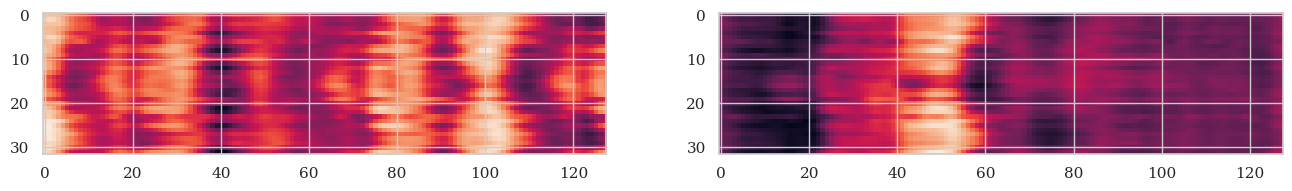

In [6]:
eeg, labels, meta = paradigm.get_data(dataset_source,[6])
eeg = (eeg - np.mean(eeg,axis=(2,),keepdims=True)) / np.std(eeg,axis=(2,),keepdims=True)
fig, ax = plt.subplots(1,2,figsize=(16,4))
ax = ax.flatten()
ax[0].imshow(eeg[labels == "NonTarget"].mean(axis=0))
ax[1].imshow(eeg[labels == "Target"].mean(axis=0))

#### Epilepsy Patients

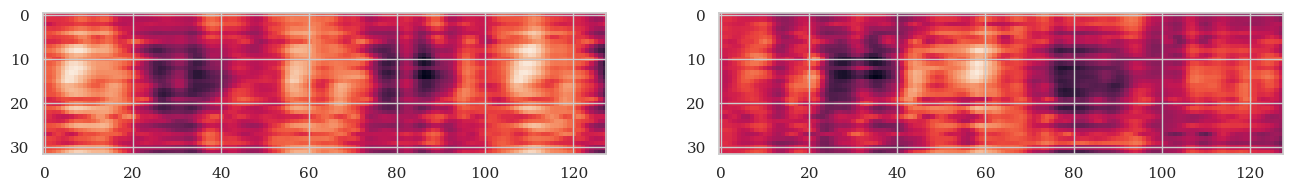

In [53]:
eeg, labels, meta = paradigm.get_data(dataset_target,[2])
eeg = (eeg - np.mean(eeg,axis=(2,),keepdims=True)) / np.std(eeg,axis=(2,),keepdims=True)
fig, ax = plt.subplots(1,2,figsize=(16,4))
ax = ax.flatten()
ax[0].imshow(eeg[labels == "NonTarget"].mean(axis=0))
ax[1].imshow(eeg[labels == "Target"].mean(axis=0))

In [6]:
evaluation = CrossSubjectEvaluation(
    paradigm=paradigm,
    datasets=[dataset_target,dataset_source],
    suffix="example",
    overwrite=True
)

In [7]:
results = evaluation.process(pipelines)

Transfer Learning-CrossSubject: 100%|██████████| 8/8 [36:34<00:00, 274.36s/it]


C:\Users\zzp99\AppData\Local\Temp\ipykernel_9004\1641943330.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\zzp99\AppData\Local\Temp\ipykernel_9004\1641943330.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


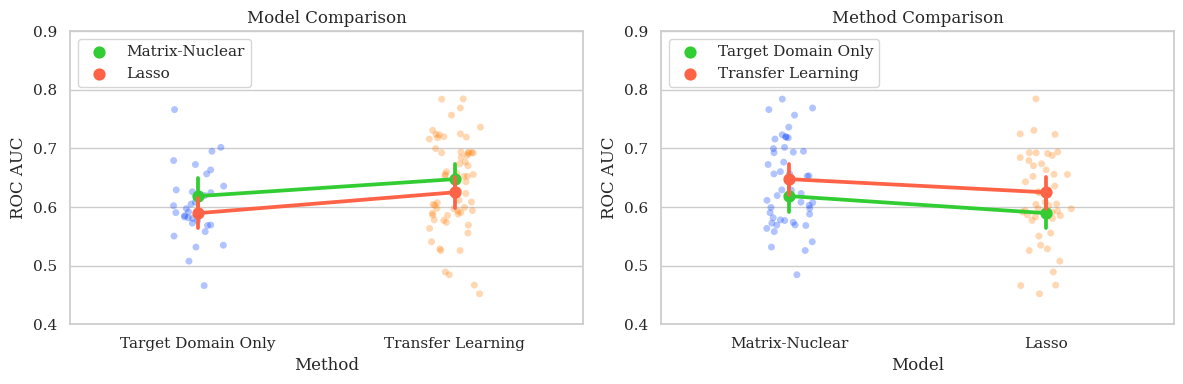

In [8]:
fig, ax = plt.subplots(1,2,facecolor="white", figsize=(12,4))
ax = ax.flatten()

sns.stripplot(
    data=results, y="score", x="dataset",
    ax=ax[0],jitter=True,alpha=0.3,zorder=1,palette="bright",
)
sns.pointplot(
    data=results, y="score", x="dataset", 
    ax=ax[0],hue="pipeline",palette=["limegreen","tomato"])
ax[0].set_ylabel("ROC AUC")
ax[0].set_xlabel("Method")
ax[0].set_ylim(0.4, 0.9)
ax[0].legend(loc="upper left")
ax[0].set_title("Model Comparison")

sns.stripplot(
    data=results, y="score", x="pipeline",
    ax=ax[1],jitter=True,alpha=0.3,zorder=1,palette="bright",
)
sns.pointplot(
    data=results, y="score", x="pipeline", 
    ax=ax[1],hue="dataset",palette=["limegreen","tomato"])
ax[1].set_ylabel("ROC AUC")
ax[1].set_xlabel("Model")
ax[1].set_ylim(0.4, 0.9)
ax[1].legend(loc="upper left")
ax[1].set_title("Method Comparison")
plt.tight_layout()